In [108]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [109]:
window_size_ms = 200.
samples_per_window = 20

n = number of windows

`all_data`: (n, samples_per_window, 6) data (acc_x,acc_y,acc_z, gyro_x, gyro_y, gyro_z)

`has_touch`: (n,) array of +/-1 (bool for whether touch occured in this window)

`touch_loc`: (n,2) array of (x,y) touch locations

All times are adjusted so the first time in the dataset is 0.

In [110]:
dataset = "dataPixelRHandStandingRandom"
with open(dataset + ".csv") as f:
    # touch_x, touch_y, sensor, t, x, y, z = row
    csvreader = csv.reader(f)
    csvf = list(csvreader)
print(csvf[0])
start_time = int(csvf[0][3])
print("Total time (s): ", (int(csvf[-1][3]) - start_time)/1000)

['-2.0', '-2.0', 'accelerometer', '1556846706990', '0.023820243775844574', '0.19748443365097046', '0.9562157988548279']
Total time (s):  216.941


In [125]:
def normalize(arr):
    """Normalizes to [-1, 1]."""
    arr_min = np.min(arr, axis=0)
    arr_range = np.ptp(arr, axis=0)
    print("Min: ", arr_min)
    print("Range: ", arr_range)
    return (2.*(arr - arr_min) / arr_range) - 1

normalize(np.array([[100, 5, 1],[200, 6, 0],[150, 0,100]]))

Min:  [100   0   0]
Range:  [100   6 100]


array([[-1.        ,  0.66666667, -0.98      ],
       [ 1.        ,  1.        , -1.        ],
       [ 0.        , -1.        ,  1.        ]])

In [126]:
# Separate acc and gyro data
acc_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "accelerometer"])

acc_data[:, 1:] = normalize(acc_data[:, 1:])

gyro_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "gyroscope"])

gyro_data[:, 1:] = normalize(gyro_data[:, 1:])

end_time = max(acc_data[-1][0], gyro_data[-1][0])
num_windows = math.ceil((end_time / window_size_ms))
num_samples = num_windows * samples_per_window
print("Total time: ", end_time)
print("Num windows:", num_windows)
print("Num samples: ", num_samples)

Min:  [-0.88349003 -0.21655588 -0.98441917]
Range:  [1.30648491 1.15038292 2.63483113]
Min:  [-2.22851562 -3.23796082 -1.67318726]
Range:  [4.85092163 7.8894043  3.61878967]
Total time:  216941.0
Num windows: 1085
Num samples:  21700


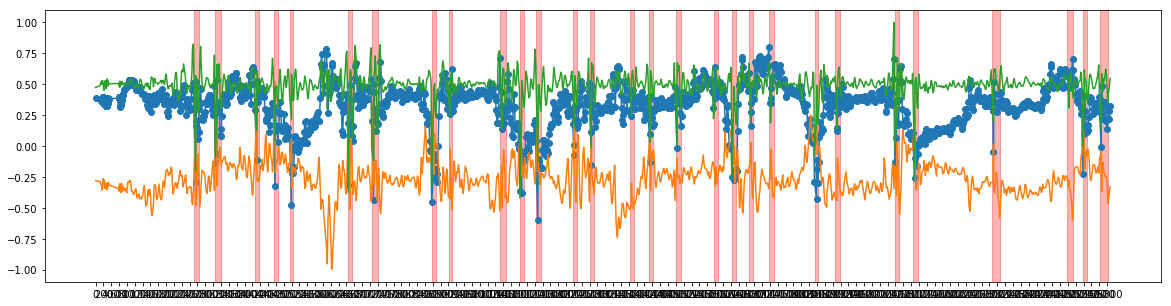

In [130]:
plt.figure(figsize=(20,5))

num_samples_to_view = 1500
plot_end_time = acc_data[num_samples_to_view - 1][0]
acc_data_t_ms = acc_data[:num_samples_to_view, 0]
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 1], marker="o")
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 2])
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 3])

presses = [int(x[3]) - start_time for x in csvf if x[2] == "press" if int(x[3]) - start_time < plot_end_time]
releases = [int(x[3]) - start_time for x in csvf if x[2] == "release" if int(x[3]) - start_time < plot_end_time]

presses = presses[:min(len(presses), len(releases))]

for i in range(len(presses)):
    plt.axvspan(presses[i], releases[i], alpha=0.3, color="r")
    
plt.xticks(np.arange(0, plot_end_time, step=200))
plt.show()

(3, 21700)
Done.


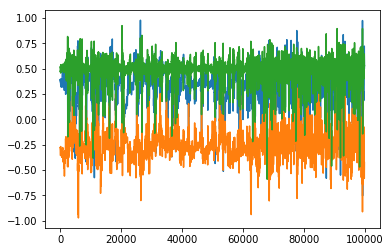

In [132]:
# Interpolate
interp_times = np.linspace(0, end_time, num=num_samples)

acc_data_ts = acc_data[:,0]
# Check times all increasing
assert(np.all(np.diff(acc_data_ts) > 0))
acc_data_interp = [
    np.interp(interp_times, acc_data_ts, acc_data[:,1]),
    np.interp(interp_times, acc_data_ts, acc_data[:,2]),
    np.interp(interp_times, acc_data_ts, acc_data[:,3]),
]

gyro_data_ts = gyro_data[:,0]
assert(np.all(np.diff(gyro_data_ts) > 0))
gyro_data_interp = [
    np.interp(interp_times, gyro_data_ts, gyro_data[:,1]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,2]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,3]),
]

num_samples_to_view = 10000
acc_data_interp = np.array(acc_data_interp)
print(acc_data_interp.shape)
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[0, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[1, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[2, :num_samples_to_view])

all_data = np.concatenate((acc_data_interp, gyro_data_interp), axis=0).T
assert(all_data.shape == (num_samples, 6))
all_data = np.array(np.split(all_data, num_windows))
assert(all_data.shape == (num_windows, samples_per_window, 6))
print("Done.")

In [133]:
# Collect touch labels
# has_touch = 1 if there is a touch ONSET in that window
# TODO: might want to test this assumption

# (# presses, 3) array of (window #, touch_x, touch_y)
press_locs = np.array([[
    int(math.floor((int(x[3]) - start_time) / window_size_ms)), float(x[0]), float(x[1])
] for x in csvf if x[2] == "press"])

has_touch = -1 * np.ones((num_windows,))
touch_loc = -2 * np.ones((num_windows, 2))

has_touch[press_locs[:,0].astype(int)] = 1
touch_loc[press_locs[:,0].astype(int)] = press_locs[:,1:]
touch_loc = normalize(touch_loc)

assert(has_touch.shape == (num_windows,))
print("Number touch windows", np.sum(has_touch == 1))
print("Number no touch windows", np.sum(has_touch == -1))
assert(touch_loc.shape == (num_windows, 2))

Min:  [-2. -2.]
Range:  [345.42855835 622.8571167 ]
Number touch windows 427
Number no touch windows 658


/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


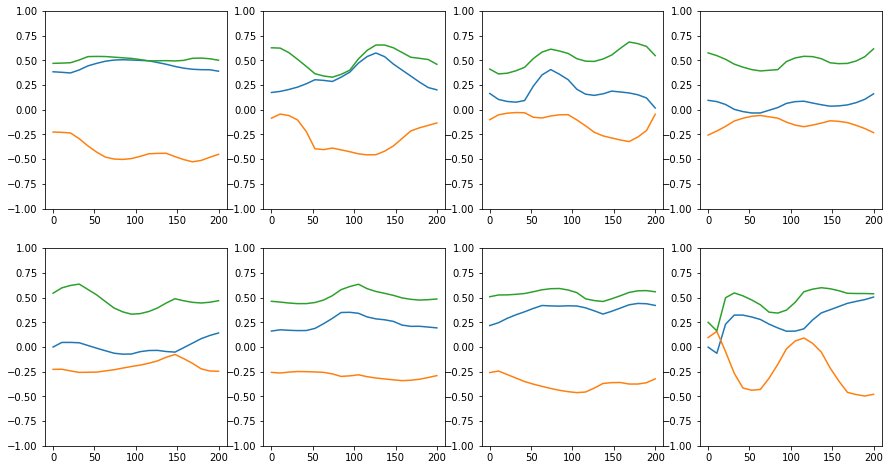

In [138]:
# Visualize touch / no touch windows
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == -1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


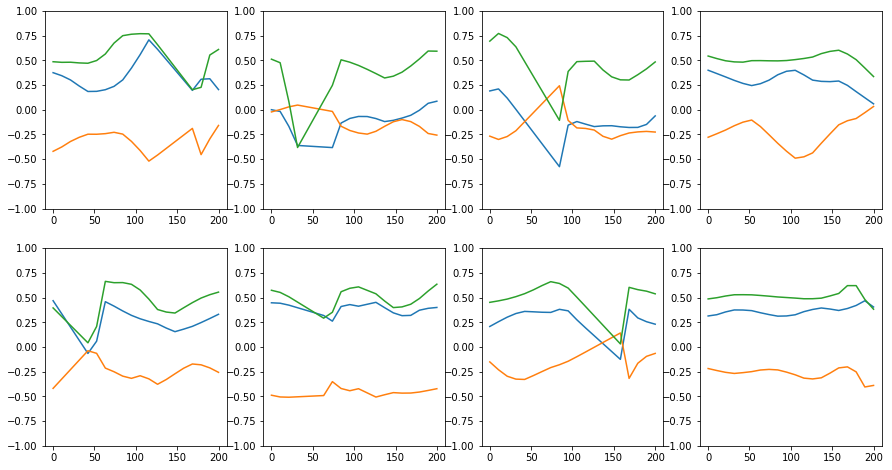

In [140]:
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == 1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

In [141]:
# Flatten into one feature vector before saving
all_data = all_data.reshape(-1, samples_per_window * 6)

print("all_data: ", all_data.shape)
print("has_touch: ", has_touch.shape)
print("touch_loc: ", touch_loc.shape)
np.save("processed/{}_x.npy".format(dataset), all_data)
np.save("processed/{}_has_touch_y.npy".format(dataset), has_touch)
np.save("processed/{}_touch_loc_y.npy".format(dataset), touch_loc)

all_data:  (1085, 120)
has_touch:  (1085,)
touch_loc:  (1085, 2)


# ~ machine learning ~

In [142]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

In [147]:
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=(samples_per_window * 6)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="tanh"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                7744      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________________________


In [148]:
skf = StratifiedKFold(n_splits = 5)

In [149]:
accs = []
for train_idx, test_idx in skf.split(all_data, has_touch):
    x_train, x_test = all_data[train_idx], all_data[test_idx]
    y_train, y_test = has_touch[train_idx], has_touch[test_idx]
    
    model.fit(x_train, y_train, epochs=100)
    _, acc = model.evaluate(x_test, y_test)
    print("ACCURACY: ", acc)
    accs.append(acc)

Epoch 1/100
867/867 [==============================] - 0s - loss: -3.4804 - acc: 0.0000e+00     
Epoch 2/100
867/867 [==============================] - 0s - loss: -5.2813 - acc: 0.0012         
Epoch 3/100
867/867 [==============================] - 0s - loss: -5.6058 - acc: 0.0196     
Epoch 4/100
867/867 [==============================] - 0s - loss: -4.8896 - acc: 0.0196     
Epoch 5/100
867/867 [==============================] - 0s - loss: -5.1140 - acc: 0.0392         
Epoch 6/100
867/867 [==============================] - 0s - loss: -5.4997 - acc: 0.0900     
Epoch 7/100
867/867 [==============================] - 0s - loss: -5.4883 - acc: 0.1776     
Epoch 8/100
867/867 [==============================] - 0s - loss: -5.5435 - acc: 0.1407     
Epoch 9/100
867/867 [==============================] - 0s - loss: -5.8276 - acc: 0.1557     
Epoch 10/100
867/867 [==============================] - 0s - loss: -6.0447 - acc: 0.1753     
Epoch 11/100
867/867 [==============================] - 0

867/867 [==============================] - 0s - loss: -6.3782 - acc: 0.7301     
Epoch 89/100
867/867 [==============================] - 0s - loss: -6.3931 - acc: 0.7301     
Epoch 90/100
867/867 [==============================] - 0s - loss: -1.9310 - acc: 0.5790     
Epoch 91/100
867/867 [==============================] - 0s - loss: 2.6333 - acc: 0.4129     
Epoch 92/100
867/867 [==============================] - 0s - loss: -5.2277 - acc: 0.4302     
Epoch 93/100
867/867 [==============================] - 0s - loss: -6.3258 - acc: 0.5098     
Epoch 94/100
867/867 [==============================] - 0s - loss: -6.4501 - acc: 0.5848     
Epoch 95/100
867/867 [==============================] - 0s - loss: -6.4240 - acc: 0.6009      
Epoch 96/100
867/867 [==============================] - 0s - loss: -6.5064 - acc: 0.5260     
Epoch 97/100
867/867 [==============================] - 0s - loss: -6.7322 - acc: 0.5836     
Epoch 98/100
867/867 [==============================] - 0s - loss: -6.635

867/867 [==============================] - 0s - loss: -6.5135 - acc: 0.7566     
Epoch 75/100
867/867 [==============================] - 0s - loss: -6.5263 - acc: 0.7624     
Epoch 76/100
867/867 [==============================] - 0s - loss: -6.5930 - acc: 0.7624     
Epoch 77/100
867/867 [==============================] - 0s - loss: -6.6028 - acc: 0.7659     
Epoch 78/100
867/867 [==============================] - 0s - loss: -6.6490 - acc: 0.7624     
Epoch 79/100
867/867 [==============================] - 0s - loss: -6.6326 - acc: 0.7624     
Epoch 80/100
867/867 [==============================] - 0s - loss: -6.6539 - acc: 0.7693     
Epoch 81/100
867/867 [==============================] - 0s - loss: -6.6801 - acc: 0.7693     
Epoch 82/100
867/867 [==============================] - 0s - loss: -6.7175 - acc: 0.7670      
Epoch 83/100
867/867 [==============================] - 0s - loss: -6.7499 - acc: 0.7716     
Epoch 84/100
867/867 [==============================] - 0s - loss: -6.78

868/868 [==============================] - 0s - loss: -6.8920 - acc: 0.7880     
Epoch 61/100
868/868 [==============================] - 0s - loss: -7.0113 - acc: 0.8041     
Epoch 62/100
868/868 [==============================] - 0s - loss: -7.0820 - acc: 0.8076     
Epoch 63/100
868/868 [==============================] - 0s - loss: -7.0870 - acc: 0.8018     
Epoch 64/100
868/868 [==============================] - 0s - loss: -7.0522 - acc: 0.7938     
Epoch 65/100
868/868 [==============================] - 0s - loss: -6.2128 - acc: 0.7316     
Epoch 66/100
868/868 [==============================] - 0s - loss: -6.1865 - acc: 0.7535     
Epoch 67/100
868/868 [==============================] - 0s - loss: -6.6050 - acc: 0.7823     
Epoch 68/100
868/868 [==============================] - 0s - loss: -6.8626 - acc: 0.7903     
Epoch 69/100
868/868 [==============================] - 0s - loss: -7.0725 - acc: 0.7949     
Epoch 70/100
868/868 [==============================] - 0s - loss: -6.770

869/869 [==============================] - 0s - loss: -7.4254 - acc: 0.8228     
Epoch 47/100
869/869 [==============================] - 0s - loss: -7.4562 - acc: 0.8285     
Epoch 48/100
869/869 [==============================] - 0s - loss: -7.4661 - acc: 0.8239     
Epoch 49/100
869/869 [==============================] - 0s - loss: -7.5188 - acc: 0.8308      
Epoch 50/100
869/869 [==============================] - 0s - loss: -0.9944 - acc: 0.5489     
Epoch 51/100
869/869 [==============================] - 0s - loss: -5.7168 - acc: 0.6985     
Epoch 52/100
869/869 [==============================] - 0s - loss: -6.9724 - acc: 0.7814     
Epoch 53/100
869/869 [==============================] - 0s - loss: -5.4267 - acc: 0.7077     
Epoch 54/100
869/869 [==============================] - 0s - loss: -5.2970 - acc: 0.7008     
Epoch 55/100
869/869 [==============================] - 0s - loss: -6.2868 - acc: 0.6824     
Epoch 56/100
869/869 [==============================] - 0s - loss: -7.08

869/869 [==============================] - 0s - loss: -6.9917 - acc: 0.8101     
Epoch 33/100
869/869 [==============================] - 0s - loss: -5.5094 - acc: 0.7250     
Epoch 34/100
869/869 [==============================] - 0s - loss: -4.1835 - acc: 0.6490    
Epoch 35/100
869/869 [==============================] - 0s - loss: -4.1677 - acc: 0.6490     
Epoch 36/100
869/869 [==============================] - 0s - loss: -4.1864 - acc: 0.6513     
Epoch 37/100
869/869 [==============================] - 0s - loss: -4.2055 - acc: 0.6536     
Epoch 38/100
869/869 [==============================] - 0s - loss: -4.2084 - acc: 0.6548     
Epoch 39/100
869/869 [==============================] - 0s - loss: -4.2089 - acc: 0.6548     
Epoch 40/100
869/869 [==============================] - 0s - loss: -4.2747 - acc: 0.6559     
Epoch 41/100
869/869 [==============================] - 0s - loss: -4.3181 - acc: 0.6594     
Epoch 42/100
869/869 [==============================] - 0s - loss: -4.3356

In [150]:
np.mean(accs)

0.7430862271827885